In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spa
import scipy.sparse.linalg as spalin
from scipy.optimize import fsolve
from tqdm import trange
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import os
import sys
sys.path.append("../dyn/")
sys.path.append("../")
sys.path.append("../phase/")
sys.path.append("../artfigs_NC/")
from dyn_ultis import *
from spatial_ultis import *
from artfigs_NC_params import *
from artfigs_NC_ultis import *

In [67]:
def generate_params_phase1p_wave_alpha_L(trial:int, trial_num:int = 41):
    trial_num = trial_num

    N_E, N_I = 10000 * 4, 2500 * 4
    alpha = 0.3
    g_bar_EE, g_bar_IE, g_bar_EI, g_bar_II = 4.68, 5, -5, -4.25
    d_EE, d_IE, d_EI, d_II = 0.05, 0.05, 0.05, 0.09
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))
    g_EE, g_EI, g_IE, g_II = 0.6,0.6,0.6,0.6

    alpha_list = np.linspace(0.1, 0.6, trial_num)
    alpha = alpha_list[trial]
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))

    p_net = Network_Params(N_E = N_E, N_I = N_I,
        N_EE = conn_NEE, N_IE = conn_NIE, N_EI = conn_NEI, N_II = conn_NII,
        d_EE = d_EE, d_IE = d_IE, d_EI = d_EI, d_II = d_II,
        g_bar_EE = g_bar_EE, g_bar_EI = g_bar_EI, g_bar_IE = g_bar_IE, g_bar_II = g_bar_II,
        g_EE = g_EE, g_EI = g_EI, g_IE = g_IE, g_II = g_II
        )
    
    return p_net  

1.0386636322810305
0.999052740057656


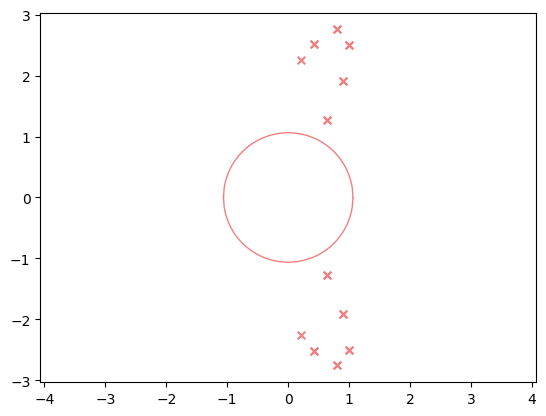

In [68]:
p_net = generate_params_phase_g_d_II_L_chaos(7,7)
radius = calc_pred_radius(p_net, dim=2)
lambda_list_pred_select, label_list_pred_select  = calc_pred_outliers(p_net, dim=2)
real_part_pred_select = np.real(lambda_list_pred_select)
imag_part_pred_select = np.imag(lambda_list_pred_select)
print(radius)
print(np.max(real_part_pred_select))
temp_plot_pred(p_net)

In [89]:
def generate_params_phase1p_wave_alpha_S(trial:int, trial_num:int = 41):
    trial_num = trial_num

    N_E, N_I = 10000, 2500
    alpha = 0.3
    g_bar_EE, g_bar_IE, g_bar_EI, g_bar_II = 4.8, 5, -5, -4.25
    d_EE, d_IE, d_EI, d_II = 0.05*2, 0.05*2, 0.05*2, 0.09*2
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))
    g_EE, g_EI, g_IE, g_II = 0.6,0.6,0.6,0.6

    alpha_list = np.linspace(0.1, 0.6, trial_num)
    alpha = alpha_list[trial]
    conn_NEE, conn_NIE, conn_NEI, conn_NII = tuple(alpha * np.array([2*np.pi * N_E * d_EE **2, 2*np.pi * N_I * d_IE **2, 2*np.pi * N_E * d_EI **2,2*np.pi * N_I * d_II **2]))

    p_net = Network_Params(N_E = N_E, N_I = N_I,
        N_EE = conn_NEE, N_IE = conn_NIE, N_EI = conn_NEI, N_II = conn_NII,
        d_EE = d_EE, d_IE = d_IE, d_EI = d_EI, d_II = d_II,
        g_bar_EE = g_bar_EE, g_bar_EI = g_bar_EI, g_bar_IE = g_bar_IE, g_bar_II = g_bar_II,
        g_EE = g_EE, g_EI = g_EI, g_IE = g_IE, g_II = g_II
        )
    
    return p_net  

0.9343577547474751
1.0258202657166022


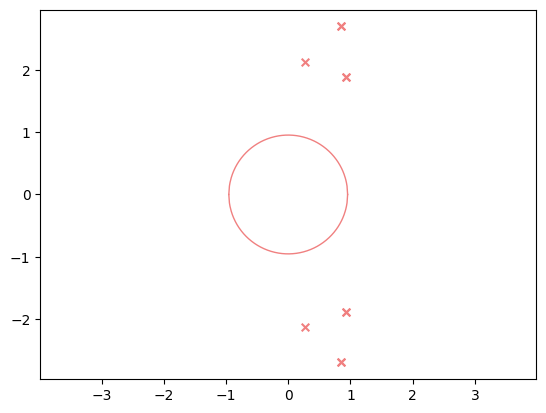

In [93]:
p_net = generate_params_phase1p_wave_alpha_S(40)
radius = calc_pred_radius(p_net, dim=2)
lambda_list_pred_select, label_list_pred_select  = calc_pred_outliers(p_net, dim=2)
real_part_pred_select = np.real(lambda_list_pred_select)
imag_part_pred_select = np.imag(lambda_list_pred_select)
print(radius)
print(np.max(real_part_pred_select))
temp_plot_pred(p_net)

In [94]:
p_simul = Simul_Params(T = 2000, t_step=5, record_step=10, activation_func=['tanh','tanh_high'], external_input="noise",tau_m=20.0)
p_net = generate_params_phase1p_wave_alpha_S(40)
record_x = dyn_simul(p_net, p_simul)

100%|██████████| 10000/10000 [02:59<00:00, 55.57it/s]


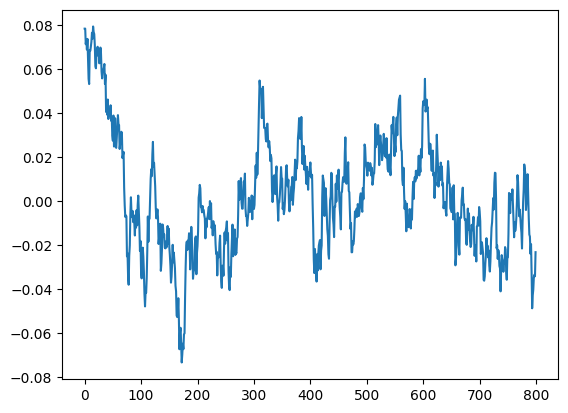

In [95]:
plt.plot(record_x[200::,100])

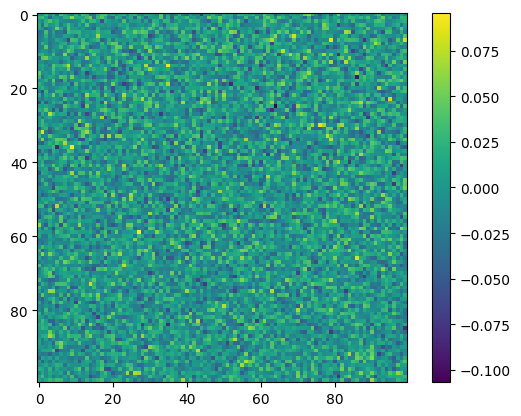

In [96]:
plt.imshow(record_x[750,0:10000].reshape((100,100)))
plt.colorbar()